# Lavaux Sensor Data: Relative Humidity 

In [66]:
import pandas as pd
import os
import glob
import numpy as np
import re
from scipy import stats
import sklearn

from sklearn.cluster import KMeans
from sklearn.neighbors import LocalOutlierFactor
from tslearn.clustering import TimeSeriesKMeans

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

%matplotlib inline

# 0. Import Temperature of all files 
readout from HOBO sensors on these dates:
1. 2022-03-08
2. 2023-05-10
3. 2023-09-20

--> First column is temperature, second one RH

In [6]:
# set the directory 
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data')

In [7]:
md = pd.read_csv('sensors_metadata.tsv', sep='\t', index_col=0)

# make dict to rename the sensor names with the plot ID 
rename_columns_dict = dict(zip(md["Sensors"], md.index))

### 1. 2021-2022

> note Lavaux_003 measured all 15 min (consider subsampling with `df['Lavaux_003'].resample('1H').mean()`)

> Sensors were installed on 2021-04-20 and read out 2022-03-08 

In [8]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2021')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,3], index_col=0) for f in all_files]
df_2022 = pd.concat(dfs, axis=1)
df_2022.index = pd.to_datetime(df_2022.index)

# sort by timestamp 
df_2022.sort_index(inplace=True)

# name columns 
df_2022 = df_2022.set_axis(names, axis=1)
df_2022.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2022 = df_2022[(df_2022.index > '2021-04-21 00:30:00') & (df_2022.index < '2022-03-08 08:00:00')]

### 2. 2022-2023 
> note two sensors have gone missing when reading out the sensors in 2023!

In [9]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_1')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,3], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023 = df_2023.set_axis(names, axis=1)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_1 = df_2023[(df_2023.index > '2022-03-08 18:00:00') & (df_2023.index < '2023-05-10 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_57320/3801189329.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2023.index = pd.to_datetime(df_2023.index)


### 3. 2023 
growing season of 2023, sensors were collected at harvest (2023-09-20)

In [10]:
os.chdir('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2023_2')
all_files = glob.glob("Lavaux_*.csv")

# get the names of the sensors 
names = []
names = [x.split('.')[0] for x in all_files]

# read in all csv files as a list of dataframes, only use the first 3 columns and set the date as index 
dfs = [pd.read_csv(f, skiprows=1, usecols=[1,3], index_col=0) for f in all_files]
df_2023 = pd.concat(dfs, axis=1)
df_2023.index = pd.to_datetime(df_2023.index)

# sort by timestamp 
df_2023.sort_index(inplace=True)

# name columns 
df_2023=df_2023.set_axis(names, axis=1)
df_2023.rename(columns=rename_columns_dict, inplace=True)

# set appropriate time frame 
df_2023_2 = df_2023[(df_2023.index > '2023-05-10 09:00:00') & (df_2023.index < '2023-09-20 08:00:00')]

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_57320/2798625086.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_2023.index = pd.to_datetime(df_2023.index)


### Agrometeo Data for Plot 19
downloaded from: https://www.agrometeo.ch/de/meteorologie/data?stations=98&sensors=1%3Aavg,1%3Amin,1%3Amax,1%3Acumsum%3A0,4%3Aavg,4%3Amin,4%3Amax,6%3Asum&from=2021-03-08&to=2023-09-30&scale=hour&groupBy=station&measured=0

In [21]:
agrometeo_data = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/2021/Agrometeo_BEL_all.csv', index_col=0)
agrometeo_data.index = pd.to_datetime(agrometeo_data.index, format="%d.%m.%Y %H:%M")
# Keep only the first column and rename it to 'Plot_18'
agrometeo_data = agrometeo_data.iloc[:, [4]].rename(columns={agrometeo_data.columns[4]: 'Plot_19'})
agrometeo_data_time = agrometeo_data[(agrometeo_data.index > '2021-04-21 00:30:00') & (agrometeo_data.index < '2023-09-20 08:00:00')]

### Merge all data

In [22]:
df_RH_2 = pd.concat([df_2022,df_2023_1,df_2023_2], join='outer', axis=0)
df_RH = pd.merge(df_RH_2, agrometeo_data_time, left_index=True, right_index=True, how='outer')

# save merged data 
df_RH.to_csv('Lavaux_all_RH_raw.csv')

df_RH.tail()

,Plot_18,Plot_15_3,Plot_4,Plot_17_1,Plot_17_5,Plot_12,Plot_17_4,Plot_20_3,Plot_9,Plot_20_5,...,Plot_15_1,Plot_15_4,Plot_14,Plot_11,Plot_20_4,Plot_17_2,Plot_15_5,Plot_13,Plot_15_2,Plot_19
2023-09-20 06:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.282,NaN
2023-09-20 06:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,92.701,NaN,NaN,NaN,NaN
2023-09-20 07:00:00,60.656,91.776,NaN,79.148,76.22,85.694,90.393,89.401,91.559,87.918,...,93.377,89.636,95.088,89.01,89.171,NaN,85.24,NaN,NaN,91.0
2023-09-20 07:20:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,90.042,NaN
2023-09-20 07:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,90.910,NaN,NaN,NaN,NaN


/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_57320/1408654224.py:5: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  show_temps = df_RH.resample('H').mean()


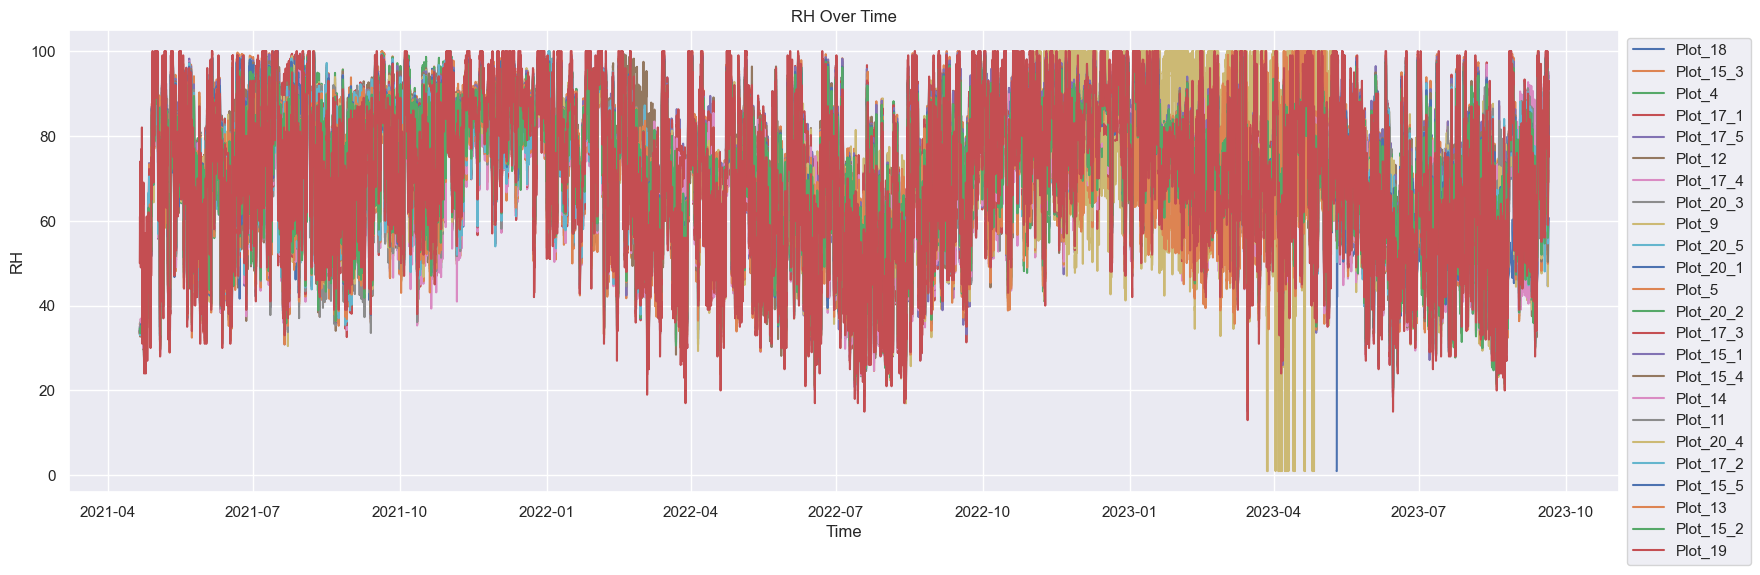

In [23]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))

# get mean temperature for each month
show_temps = df_RH.resample('H').mean()

# loop over columns and plot temperatures 
for column in show_temps.columns:
    plt.plot(show_temps.index, show_temps[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('RH')
plt.title('RH Over Time')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

plt.show()

# 1. Outlier correction with MAD 
see Temperature script for more tests and info

In [24]:
MAD_threshold = 3.5

MAD_window = 24
MAD_neighbors = 5

In [25]:
# function to compare each value to other values at this timestamp and to remove values outside of the specified threshold 

def remove_outliers(row, num_neighbors = MAD_neighbors, threshold = MAD_threshold):
    # Find non-NaN values in the row
    non_na_indices = row.dropna().index
    
    # If there are fewer than num_neighbors non-NaN values, return the original row
    if len(non_na_indices) < num_neighbors:
        return row
    
    # Extract values for comparison
    values_to_compare = row[non_na_indices].values
    
    # Calculate the median and median absolute deviation (MAD)
    median_value = np.median(values_to_compare)
    mad = np.median(np.abs(values_to_compare - median_value))
    
    # Identify indices of outliers based on the MAD and threshold
    outlier_indices = non_na_indices[np.abs(values_to_compare - median_value) > threshold * mad]
    
    # Replace outliers with NaN
    row[outlier_indices] = pd.NA
    
    return row

In [26]:
# Remove outliers using rolling Median Absolute Deviation (MAD) for each column.

def remove_outliers_rolling(df, window_size = MAD_window, threshold = MAD_threshold):

    result_df = df.copy()

    for column in df.columns:
        column_data = df[column]

        # Use rolling median and rolling MAD
        rolling_median = column_data.rolling(window=window_size, min_periods=1, center=True).median()
        rolling_mad = column_data.rolling(window=window_size, min_periods=1, center=True).apply(lambda x: np.median(np.abs(x - np.median(x))))

        # Identify outliers
        outliers = np.abs(column_data - rolling_median) > threshold * rolling_mad

        # Mark outliers in the result DataFrame with NaN
        result_df.loc[outliers, column] = pd.NA

    return result_df

In [27]:
# let's resample per hour 
df = df_RH.resample('H').mean()

# Apply the remove_outliers function to each column in the DataFrame
df_outliers_MAD = df.apply(remove_outliers, axis=1)

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_57320/3732604292.py:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df_RH.resample('H').mean()


In [28]:
# Set window size and apply the function
df_outliers_rollingMAD = remove_outliers_rolling(df)

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_57320/913426959.py:4: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  resampled_counts = df_RH.resample('H').mean().count()


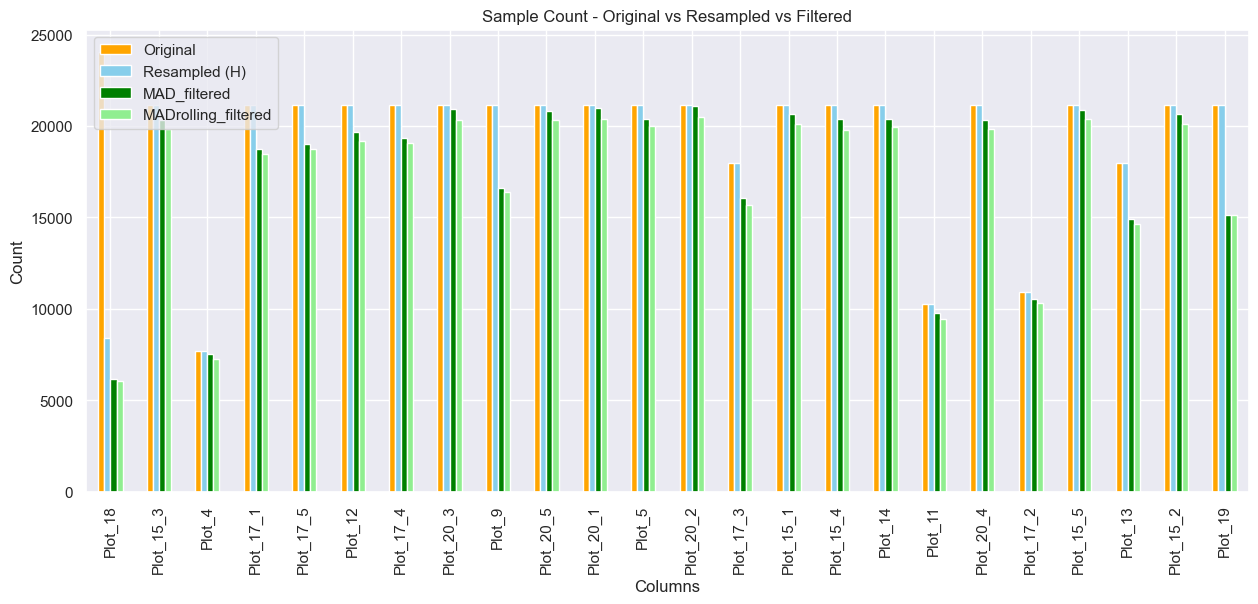

In [29]:
## quickly show how many entries we "loose" from resampling 

original_counts = df_RH.count()
resampled_counts = df_RH.resample('H').mean().count()
MAD_counts = df_outliers_MAD.count()
MADrolling_counts = df_outliers_rollingMAD.count()

# Create a DataFrame for plotting
plot_data = pd.DataFrame({'Original': original_counts, 'Resampled (H)': resampled_counts, 'MAD_filtered' : MAD_counts, 'MADrolling_filtered' : MADrolling_counts})

# Plot the grouped bar chart
ax = plot_data.plot(kind='bar', figsize=(15, 6), color=['orange','skyblue','green', 'lightgreen'])

# Set plot labels and title
ax.set_ylabel('Count')
ax.set_xlabel('Columns')
ax.set_title('Sample Count - Original vs Resampled vs Filtered')

# Display legend
ax.legend()

# Show the plot
plt.show()


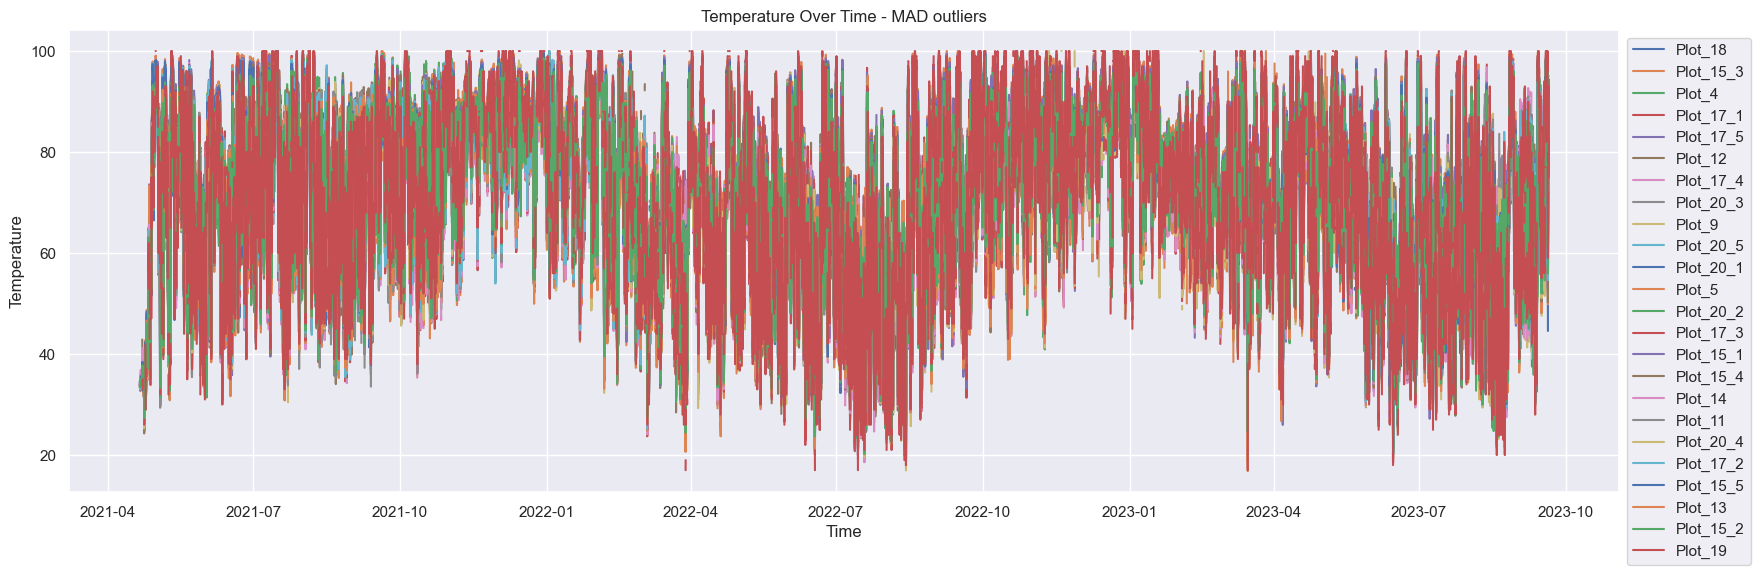

In [30]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_MAD.columns:
    plt.plot(df_outliers_MAD.index, df_outliers_MAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD outliers')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

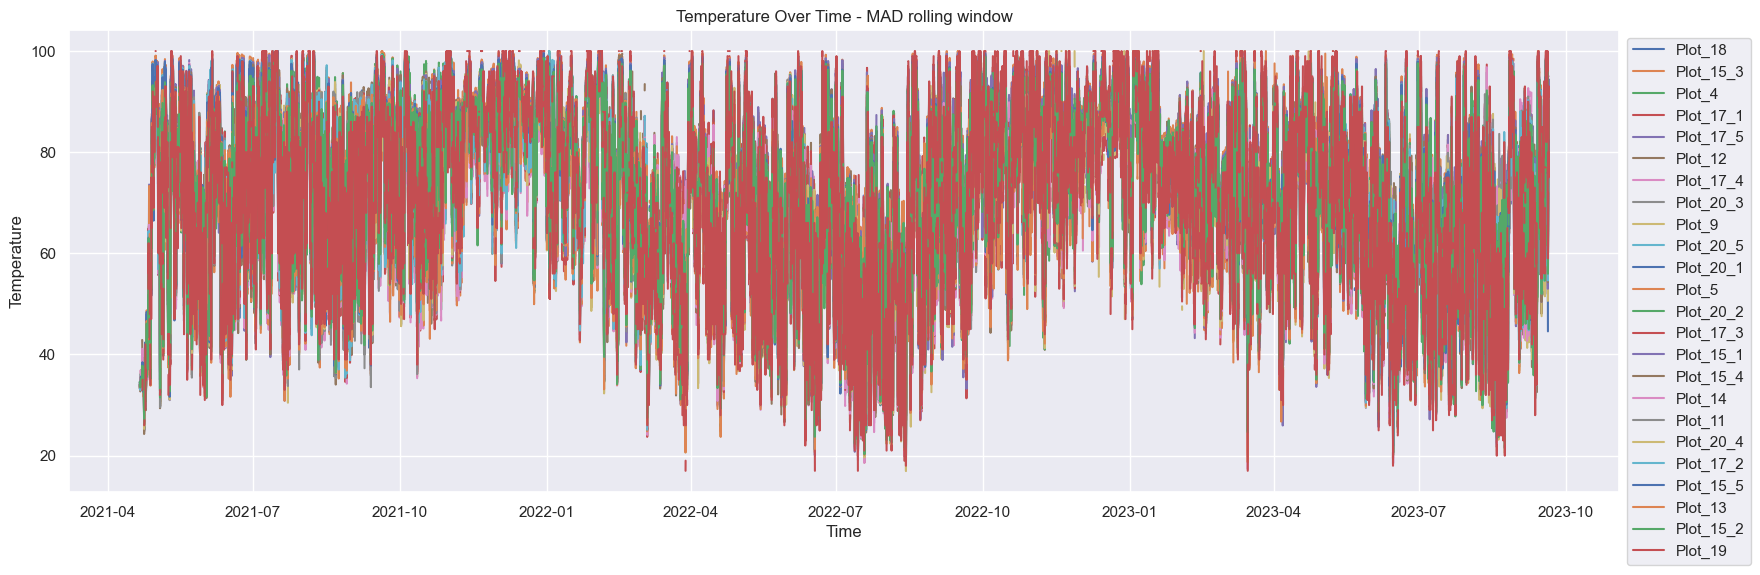

In [31]:
# plot monthly temperature over the 3 years 
plt.figure(figsize=(20, 6))


# loop over columns and plot temperatures 
for column in df_outliers_rollingMAD.columns:
    plt.plot(df_outliers_rollingMAD.index, df_outliers_rollingMAD[column], label=column)

# some labeling 
plt.xlabel('Time')
plt.ylabel('Temperature')
plt.title('Temperature Over Time - MAD rolling window')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)

# save figure 
#plt.savefig('Graphs/all_sensors.png', format='png')

plt.show()

In [33]:
# Save the outlier corrected data 
df_outliers_MAD.to_csv('Lavaux_all_RH_OutliersRemoved.csv')
df_outliers_MAD.head()

,Plot_18,Plot_15_3,Plot_4,Plot_17_1,Plot_17_5,Plot_12,Plot_17_4,Plot_20_3,Plot_9,Plot_20_5,...,Plot_15_1,Plot_15_4,Plot_14,Plot_11,Plot_20_4,Plot_17_2,Plot_15_5,Plot_13,Plot_15_2,Plot_19
2021-04-21 00:00:00,34.11200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-21 01:00:00,33.98650,NaN,34.966,33.746,33.818,33.422,34.075,35.053,34.576,33.987,...,33.626,33.588,34.441,33.841,33.389,33.391,34.576,33.856,34.512,NaN
2021-04-21 02:00:00,33.83350,NaN,NaN,33.577,33.712,33.321,33.838,NaN,34.437,33.816,...,33.584,33.447,34.073,33.768,33.318,33.318,34.307,33.814,34.309,NaN
2021-04-21 03:00:00,33.66200,NaN,34.622,33.442,33.639,33.183,33.633,NaN,34.300,33.644,...,33.544,33.336,33.834,33.695,33.310,33.245,34.106,33.772,34.106,NaN
2021-04-21 04:00:00,33.51675,NaN,34.481,33.239,33.566,33.048,33.496,34.574,34.161,33.471,...,33.502,33.226,33.628,33.620,33.235,33.237,33.900,33.730,33.936,NaN


# 2. Comparing the years 

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_57320/1049619901.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/lfloerl/miniconda3/envs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1075: F

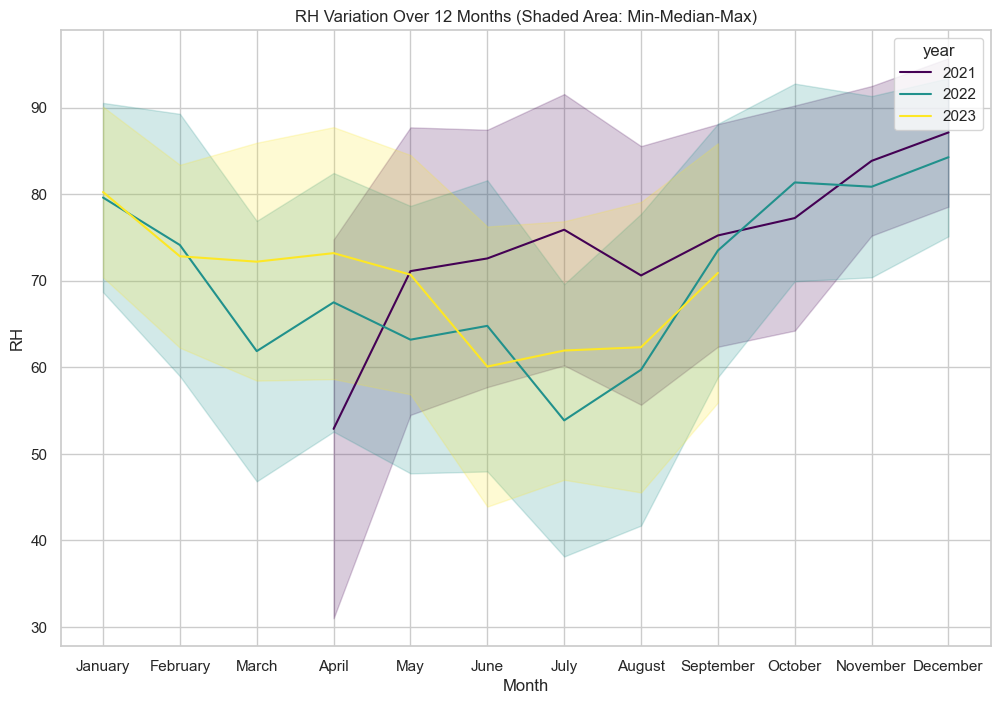

In [34]:
df = df_outliers_MAD.copy()

# Extract year and month from the timestamp
df['year'] = df.index.year
df['month'] = df.index.month
df_melted = pd.melt(df, id_vars=['year', 'month'], var_name='temperature_type', value_name='temperature')

# Create a line plot with shaded area using seaborn
plt.figure(figsize=(12, 8))

sns.set_style("whitegrid")

sns.lineplot(x='month', y='temperature', hue='year', ci='sd', data=df_melted, palette="viridis")
plt.title('RH Variation Over 12 Months (Shaded Area: Min-Median-Max)')
plt.xlabel('Month')
plt.ylabel('RH')

# Customize x-axis ticks for every month
plt.xticks(range(1, 13), [pd.to_datetime(str(i), format='%m').strftime('%B') for i in range(1, 13)])

plt.show()

# 3. Interplot variance

### Statistical testing 

> mean temperatures of months / weeks **are not** statistically significant between each other 

In [35]:
df = df_outliers_MAD

In [36]:
# Perform Kruskal-Wallis test on each row
p_values = []
for _, row in df.iterrows():
    _, p_value = stats.kruskal(*row.values)
    p_values.append(p_value)

# Create a new DataFrame with p-values
p_value_df = pd.DataFrame({'P-Value': p_values}, index=df.index)

# Filter and print rows with significant p-values
significant_rows = p_value_df[p_value_df['P-Value'] < 0.05]
print(significant_rows)

Empty DataFrame
Columns: [P-Value]
Index: []


### Add some metadata

In [37]:
# Merge the dataframes based on the sensor name (reset the index first) and sort: first by altitude and then by plot 
ave_RH_new = df_outliers_MAD.reset_index() 
md_renamed = md.reset_index()
merged_df = ave_RH_new.melt(id_vars='index', var_name='ID', value_name='RH').merge(md, on='ID').sort_values(by = ['Altitude', 'ID'])

### Boxplots

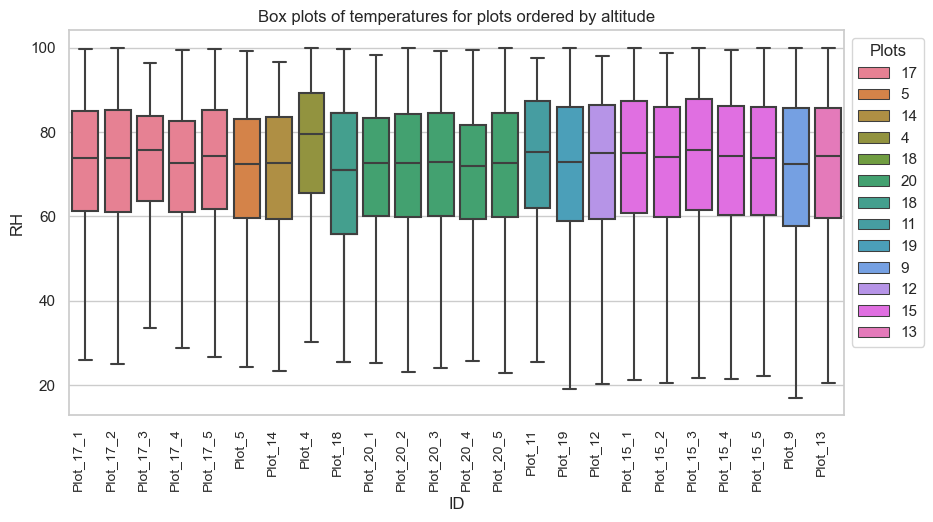

In [38]:
plt.figure(figsize=(10,5))

plots_ordered_by_altitude = [17, 5, 14, 4, 18, 20, 18, 11, 19, 9, 12, 15, 13]

ax = sns.boxplot(x='ID', y='RH', hue="Plots", 
                 width=0.8, dodge=False,
                 data=merged_df, palette="husl", 
                 hue_order=plots_ordered_by_altitude,
                 showfliers = False
                 )

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

plt.title('Box plots of temperatures for plots ordered by altitude')

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=90, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'
)
None
# the None is to not show the lables as output 

### Heatmaps

In [39]:
df = df_outliers_MAD.copy()

# Extract unique plot names
plot_names = set('_'.join(col.split('_')[:2]) for col in df.columns)
plot_names

# Calculate median for each group of columns with the same plot name
median_values = {}
for plot_name in plot_names:
    columns = [col for col in df.columns if plot_name in col]
    median_values[plot_name] = df[columns].median(axis=1)

# Concatenate median values into a new DataFrame
df_median = pd.DataFrame(median_values)

df_median

,Plot_19,Plot_15,Plot_13,Plot_12,Plot_4,Plot_9,Plot_11,Plot_20,Plot_17,Plot_14,Plot_5,Plot_18
2021-04-21 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,34.11200
2021-04-21 01:00:00,NaN,34.0690,33.856,33.422,34.966,34.576,33.841,34.0770,33.8180,34.441,33.781,33.98650
2021-04-21 02:00:00,NaN,33.9455,33.814,33.321,NaN,34.437,33.768,33.8285,33.7120,34.073,33.577,33.83350
2021-04-21 03:00:00,NaN,33.8250,33.772,33.183,34.622,34.300,33.695,33.6385,33.6330,33.834,33.372,33.66200
2021-04-21 04:00:00,NaN,33.7010,33.730,33.048,34.481,34.161,33.620,33.4710,33.4960,33.628,33.235,33.51675
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-09-20 03:00:00,79.0,85.2030,NaN,85.675,NaN,82.553,79.940,83.2990,84.4910,NaN,83.741,NaN
2023-09-20 04:00:00,83.0,84.6720,NaN,85.963,NaN,85.901,82.026,84.6450,87.5075,NaN,84.134,NaN
2023-09-20 05:00:00,87.0,88.1370,NaN,85.657,NaN,86.684,84.162,89.4830,89.9480,94.969,86.491,NaN
2023-09-20 06:00:00,93.0,90.2820,NaN,NaN,NaN,90.882,89.459,89.0380,90.2470,95.013,86.154,NaN


In [40]:
# Create heatmap
df_heatmap = df_median.T

# Get month names
monthly = df_median.resample('M').mean()
month_names = monthly.index.strftime('%B, %Y')

# Heatmap 
plt.figure(figsize=(20, 5), dpi=1000)
heatmap = sns.heatmap(data=df_heatmap, cmap='BrBG', annot=None, 
                      cbar_kws={'label': 'Relative Humidity [%]', 'shrink': 0.7, 'aspect': 15, 'pad': 0.02})
#plt.title('Heatmap of all plots over the years')

# Set custom x-axis labels
n = len(month_names)
heatmap.set_xticks(np.linspace(0, n - 1, n))
heatmap.set_xticklabels(month_names)

# Calculate positions for the labels
width = heatmap.get_xlim()[1] - heatmap.get_xlim()[0]
positions = np.linspace(heatmap.get_xlim()[0], heatmap.get_xlim()[1], len(month_names))

# Set label positions
plt.xticks(positions, month_names)

plt.tight_layout()
plt.show()

/var/folders/vs/cscnsm_n1pq4d37fdkylmm940000gq/T/ipykernel_57320/189549149.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly = df_median.resample('M').mean()


# Get RH for growing season and clean 

In [41]:
# Function to filter columns with >90% data coverage
def filter_columns_with_data(df, start_date, end_date, threshold=0.9):
    # Subset data for the growing season
    df_season = df[(df.index >= start_date) & (df.index <= end_date)]
    # Resample to daily counts
    daily_counts = df_season.resample('D').count()
    # Calculate the percentage of days with data for each column
    days_in_season = len(daily_counts)
    valid_columns = daily_counts.sum() / days_in_season > threshold
    return df_season.loc[:, valid_columns]

In [42]:
# subset to season
df_21 = df_outliers_MAD[(df_outliers_MAD.index > '2021-04-01') & (df_outliers_MAD.index < '2021-09-30')]
df_22 = df_outliers_MAD[(df_outliers_MAD.index > '2022-04-01') & (df_outliers_MAD.index < '2022-09-30')]
df_23 = df_outliers_MAD[(df_outliers_MAD.index > '2023-04-01') & (df_outliers_MAD.index < '2023-09-30')]

In [47]:
# Remove plots with insufficient data (90% of data)
df_21_cleaned = filter_columns_with_data(df_21, '2021-04-01', '2021-09-30')
df_22_cleaned = filter_columns_with_data(df_22, '2022-04-01', '2022-09-30')
df_23_cleaned = filter_columns_with_data(df_23, '2023-04-01', '2023-09-30')

# drop the sensor for Plot17_3 from the 2023 dataset because it's flawed
df_23_cleaned.drop(columns=['Plot_17_3'], inplace=True) 


In [48]:
df_23_cleaned.head()

,Plot_18,Plot_15_3,Plot_17_1,Plot_17_5,Plot_12,Plot_17_4,Plot_20_3,Plot_9,Plot_20_5,Plot_20_1,...,Plot_15_1,Plot_15_4,Plot_14,Plot_11,Plot_20_4,Plot_17_2,Plot_15_5,Plot_13,Plot_15_2,Plot_19
2023-04-01 01:00:00,NaN,84.713,72.113,71.484,82.842,77.040,75.812,NaN,77.693,76.563,...,83.069,80.633,78.485,NaN,76.042,NaN,81.322,NaN,82.495,83.0
2023-04-01 02:00:00,NaN,77.274,78.279,78.404,76.204,75.418,72.581,NaN,74.437,73.645,...,76.466,75.408,74.254,NaN,73.244,NaN,74.995,NaN,76.674,72.0
2023-04-01 03:00:00,NaN,82.580,74.602,76.052,80.272,76.006,76.160,NaN,77.503,76.664,...,81.363,79.068,76.815,NaN,76.160,NaN,80.530,NaN,80.972,79.0
2023-04-01 04:00:00,NaN,80.599,76.994,77.484,79.255,73.028,74.228,NaN,74.638,72.806,...,78.787,74.429,73.007,NaN,72.358,NaN,76.867,NaN,76.726,76.0
2023-04-01 05:00:00,NaN,79.139,81.475,82.160,77.976,75.118,76.554,NaN,76.423,74.958,...,78.815,79.929,75.982,NaN,74.952,NaN,77.302,NaN,78.696,75.0


In [52]:
def calculate_rh_metrics(df, year):
    # Resample to daily data if needed (assumed hourly data for this example)
    df_daily = df.resample('D').mean()  # Resampling to daily averages

    # Calculate required metrics for each plot
    metrics = pd.DataFrame(index=df.columns)  # Plot IDs as index
    
    metrics['average_rh'] = df_daily.mean()  # Daily average RH
    metrics['maximum_rh'] = df_daily.max()  # Maximum RH
    metrics['minimum_rh'] = df_daily.min()  # Minimum RH
    
    # Calculate coefficient of variation (CV)
    metrics['cv_rh'] = df_daily.std() / df_daily.mean() * 100  # CV as percentage
    
    metrics['Year'] = int(year)  # Add the year for each metric (useful for merging later)

    # Reset index and rename the index to 'Plot'
    metrics.reset_index(inplace=True)
    metrics.rename(columns={'index': 'Plot'}, inplace=True)

    return metrics

# Calculate metrics for each year
rh_metrics_21 = calculate_rh_metrics(df_21_cleaned, 2021)
rh_metrics_22 = calculate_rh_metrics(df_22_cleaned, 2022)
rh_metrics_23 = calculate_rh_metrics(df_23_cleaned, 2023)

In [53]:
rh_metrics_23

,Plot,average_rh,maximum_rh,minimum_rh,cv_rh,Year
0,Plot_18,52.546145,67.650000,40.778125,9.384458,2023
1,Plot_15_3,68.085859,95.929000,40.887727,17.420752,2023
2,Plot_17_1,67.699640,93.863333,39.963143,16.131628,2023
3,Plot_17_5,67.397839,91.790609,39.337100,16.028348,2023
4,Plot_12,65.450134,88.513389,39.781696,16.223530,2023
5,Plot_17_4,67.663708,92.683292,40.625636,14.950827,2023
6,Plot_20_3,66.306406,92.211750,42.017739,16.552949,2023
7,Plot_9,64.774039,100.000000,39.682810,19.755500,2023
8,Plot_20_5,65.958737,91.648917,39.924833,17.334519,2023
9,Plot_20_1,65.889752,90.939708,41.077750,16.671106,2023


In [54]:
# combine the dfs for different years 
rh_metrics_combined = pd.concat([rh_metrics_21, rh_metrics_22, rh_metrics_23], ignore_index=True)
rh_metrics_combined.to_csv('Lavaux_all_RH_Metrics.csv')

rh_metrics_combined.head()

,Plot,average_rh,maximum_rh,minimum_rh,cv_rh,Year
0,Plot_18,72.158210,98.905010,32.434750,16.733438,2021
1,Plot_15_3,73.574767,99.998250,31.822286,16.338342,2021
2,Plot_4,72.828615,99.036583,33.078261,16.567322,2021
3,Plot_17_1,74.276873,97.040429,32.670542,18.142214,2021
4,Plot_17_5,72.076768,96.638167,32.547667,16.141023,2021


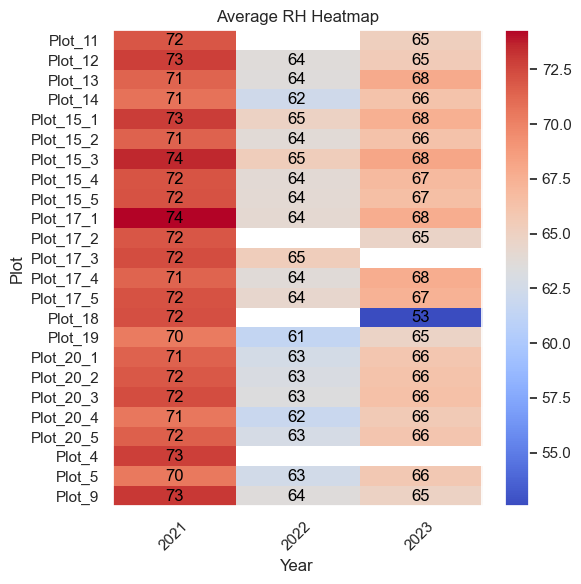

In [68]:

# Assuming rh_metrics_23 contains the data for 'average_rh' and you have the corresponding year and Plot columns
# Reformat rh_metrics_23 to have the 'Year' as columns and 'Plot' as rows
rh_pivot = rh_metrics_combined.pivot_table(index='Plot', columns='Year', values='average_rh')

# Create a figure and axis for the heatmap
plt.figure(figsize=(6, 6))

# Plot the heatmap using imshow
cax = plt.imshow(rh_pivot, cmap='coolwarm', aspect='auto')

# Add a colorbar to the heatmap
plt.colorbar(cax)

# Annotate the cells with values
for i in range(rh_pivot.shape[0]):  # Loop through rows (plots)
    for j in range(rh_pivot.shape[1]):  # Loop through columns (years)
        value = rh_pivot.iloc[i, j]
        if not np.isnan(value):  # Skip NaN values
            plt.text(j, i, f'{value:.0f}', ha='center', va='center', color='black')

# Set axis labels
plt.xticks(ticks=np.arange(rh_pivot.shape[1]), labels=rh_pivot.columns, rotation=45)
plt.yticks(ticks=np.arange(rh_pivot.shape[0]), labels=rh_pivot.index)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Plot')
plt.title('Average RH Heatmap')

plt.grid(False)  # Disable grid
plt.gca().set_facecolor('white')  # Set background to white

# Show the plot
plt.tight_layout()
plt.show()


# Merge Temperature and RH data to make one big Climate df

In [65]:
temp_df = pd.read_csv('/Users/lfloerl/Desktop/MICROTERROIR/Data/Sensor_Data/Lavaux_all_Temp_Metrics.csv')

climate_df = pd.merge(rh_metrics_combined, temp_df, on=('Plot', 'Year'), how='outer')
climate_df = climate_df.drop(columns=['Unnamed: 0'])

climate_df.to_csv('/Users/lfloerl/Desktop/MICROTERROIR/microterroir/Microbiome/Metadata/RawMD-Lavaux-Climate.csv')

climate_df.head()

,Plot,average_rh,maximum_rh,minimum_rh,cv_rh,Year,GDD,average_temperature,maximum_temperature,minimum_temperature,accumulated_temperature,cv_temperature
0,Plot_11,71.948958,96.437167,32.357792,16.118351,2021,1297.271087,17.964399,26.775286,7.966542,2910.232671,23.246939
1,Plot_11,NaN,NaN,NaN,NaN,2022,NaN,NaN,NaN,NaN,NaN,NaN
2,Plot_11,65.129839,89.972190,35.906250,15.448470,2023,1370.143986,22.686518,30.040261,13.889263,2450.143986,13.681665
3,Plot_12,72.753295,97.113875,32.104636,16.661423,2021,1286.822875,17.897069,27.509143,7.779875,2899.325119,23.615955
4,Plot_12,63.602896,93.589375,38.196130,19.677382,2022,1758.322214,19.428428,31.271750,1.029250,3535.973846,30.369938
